# Stochastic epidemic models



We will code a stochastic epidemic model using the Gillespie algorithm, and explore its properties through numerical simulations. We will use the standard SIR model, which has three variables and two parameters. The Gillespie algorithm simulates two events, infection and recovery: from the point of view of the number of infected individuals, this is a birth-death process with non-linear rates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Random number generator (arbitrary seed)
rng = np.random.default_rng(234)

# Section 1 - Deterministic model

We consider a simple epidemic model in a closed population with variables S(t) for susceptible individuals, I(t) for infected and R(t) for recovered, and total population size N(t). Transmission occurs by direct contact between susceptible and infected individuals at rate $\beta S(t) I(t)/N(t)$. Infected individuals recover at rate $\gamma$ and remain immune to reinfection in the R compartment. The basic reproductive ratio is $R_0 = \beta/\gamma$.

The deterministic model can be written as a set of ordinary differential equations:

$$
\begin{align}
	\frac{dS}{dt} &= - \beta \frac{S I}{N}  \\
	\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I  \\
	\frac{dR}{dt} &= \gamma I
\end{align}
$$

In [2]:
def sir_ode_basic(t,X,beta,gamma):
    dS = -beta * X[0]*X[1]/X.sum()
    dI = beta * X[0]*X[1]/X.sum() - gamma * X[1]
    dR = gamma * X[1]
    return [dS,dI,dR]

# or in a more concise form:
def sir_ode(t,X,beta,gamma):
    inf = beta * X[0]*X[1]/X.sum()
    rec = gamma * X[1]
    return [-inf,inf-rec,rec]

Testing these functions with `X=np.array([1,1,0])`, beta=1 and gamma=1.

In [3]:
sir_ode(0,np.array([1,1,0]),1,1)

[-0.5, -0.5, 1]

Testing deterministic SIR model with beta = 1, gamma = 0.5 and initial conditions `X0 = np.array([99,1,0])`.

In [4]:
beta = 1
gamma = 0.5
X0 = np.array([99,1,0])
t_max = 40
t = np.linspace(0, t_max, 300)

sir_sol_1 = solve_ivp(sir_ode,[0,t_max],X0,args=(beta,gamma), dense_output=True)

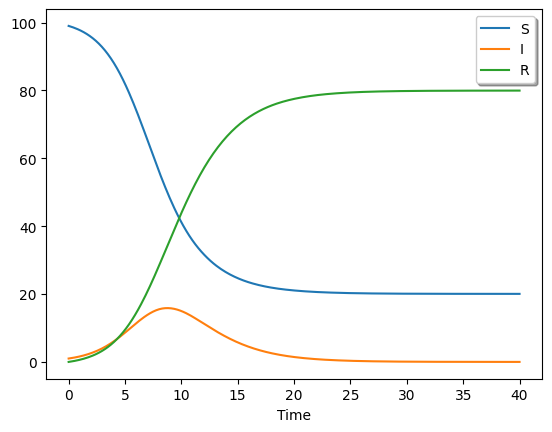

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel("Time")

ax.plot(t,sir_sol_1.sol(t).T)
ax.legend(['S', 'I', 'R'], shadow=True)
plt.show()

# Secion 2 - Stochastic model

We implement the Gillespie algorithm with two events:

* Transmission: rate = $\beta*S*I/N$, effect: (S = S-1, I = I+1)
* Recovery:     rate = $\gamma*I$,    effect: (I = I-1, R = R+1)

Algorithm:

1.  Initialise the time (t=0) and population size ($X=X_0$)
2.  Stop if $I=0$ or $t>t_{max}$
3.  Draw the time to the next event , $u$, from an exponential distribution with rate $\beta*S*I/N+\gamma*I$
4.  Update $t = t+u$
5.  Draw a random number z from a uniform distribution between 0 and 1
6.  If $z<\beta*S/(\beta*S+\gamma*N)$ then update X = X+[-1,1,0], Else update X = X+[0,-1,1].
7.  Store t and X
8.  Go back to step 2.

In [7]:
def sir_sim(t_max, X0, beta, gamma):
    # Initialisation
    times = np.array([0.0])
    t = 0.0
    X = np.array(X0)
    sol = np.array([X0])

    # Run
    while((t<t_max) & (X[1]>0)):
        inf_rate = beta*X[0]*X[1]/X.sum()
        rec_rate = gamma*X[1]
        # Draw the next time step:
        u = rng.exponential(1/(inf_rate+rec_rate))
        # Store the new value of t
        t = t+u
        times = np.append(times,t)
        # Choose the next event:
        z = rng.random()
        if z<inf_rate/(inf_rate+rec_rate):
            X = X + [-1,1,0]
        else:
            X = X + [0,-1,1]
        # Store the new state:
        sol = np.append(sol,[X],axis=0)
    return times, sol



Testing this function.

In [8]:
beta = 1
gamma = 0.5
X0 = np.array([99,1,0])
t_max = 30

t_1, sol_1 = sir_sim(t_max, X0, beta,gamma)

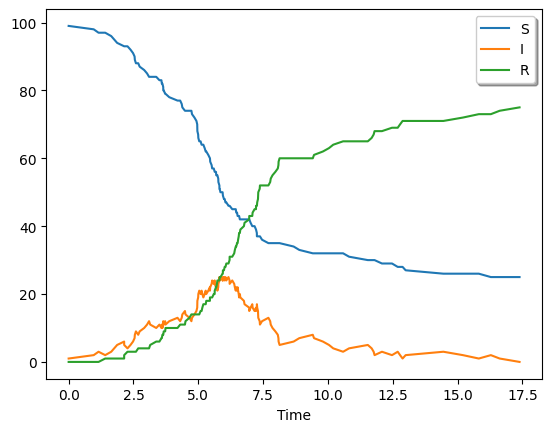

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel("Time")

ax.plot(t_1,sol_1)
ax.legend(['S', 'I', 'R'], shadow=True)

plt.show()

We will now run 10 simulations from the same model, but only storing the values of t and I(t). We will then plot the 10 trajectories of I(t), to show how many simulations end without causing an outbreak.

In [11]:
# Define the parameters
beta = 1
gamma = 0.5
X0 = np.array([99,1,0])
t_max = 30
n_sim = 10

sim_sir_10 = np.array([[0, 0, X0[1]]])

# Loop
for i in range(n_sim):
    t_i, sim_i = sir_sim(t_max, X0, beta,gamma)
    index = np.full(t_i.shape,i)
    out = np.array([index,t_i,sim_i[:,1]]).T
    sim_sir_10 = np.append(sim_sir_10, out, axis=0)



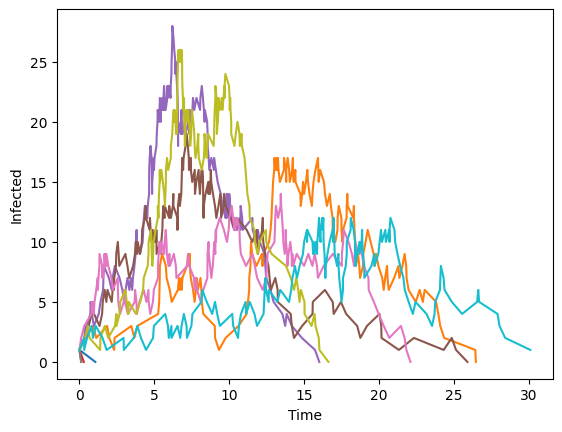

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("Time")
ax.set_ylabel("Infected")

for i in range(n_sim):
    sim_i = sim_sir_10[sim_sir_10[:,0]==i,:]
    ax.plot(sim_i[:,1], sim_i[:,2])
plt.show()

The probability of early extinction can be estimated by counting the number of simulations that end within 5 generations (i.e. 5 times the mean infectious period). This can be compared to the theoretical value:

$$
p_{ex}=(1/R_0)^{I(0)}
$$

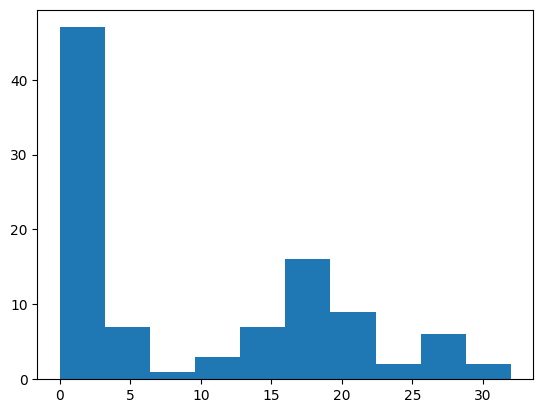

In [13]:
beta = 1
gamma = 0.5
X0 = np.array([99,1,0])
t_max = 30
n_sim = 100

end_sim_sir = np.zeros(n_sim)

# Loop
for i in range(n_sim):
    t_i, sim_i = sir_sim(t_max, X0, beta,gamma)
    end_sim_sir[i] = t_i[-1]

plt.hist(end_sim_sir)
plt.show()

In [14]:
(end_sim_sir<(5/gamma)).sum()/n_sim

0.55

# Section 3 - Final epidemic size

The final epidemimic size is the total number of cases that have occurred during the course of the epidemic. In this model, all cases eventually recover, so the final epidemic size can be obtained by recording the final value of compartment R(t).

In [15]:
def sir_fes(n_sim, t_max, X0, beta, gamma):
    fes = np.zeros(n_sim)
    for i in range(n_sim):
        t_i, sim_i = sir_sim(t_max, X0, beta,gamma)
        fes[i] = sim_i[-1,2]
    return fes


In [16]:
beta = 1
gamma = 0.5
X0 = np.array([99,1,0])
t_max = 50
n_sim = 100

fes_1 = sir_fes(n_sim,t_max,X0,beta,gamma)

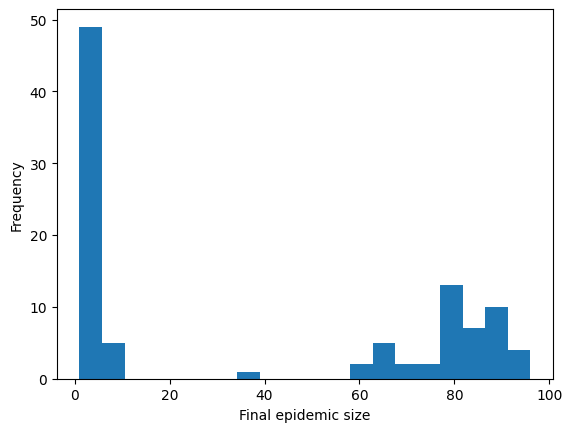

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel("Final epidemic size")
ax.set_ylabel("Frequency")

plt.hist(fes_1, bins=20)
plt.show()

The mean final epidemic size (FES) can be compared with that of the deterministic model.

In [18]:
# Deterministic final epidemic size:
sol_1[-1,2]

75

In [19]:
np.mean(fes_1)

37.57

We can caculate the mean FES for the subset of simulations that didn't go extinct. This requires choosing an arbitrary criterion, for example based on the histogram: select values > 20.

In [20]:
np.mean(fes_1[fes_1>20])

79.32608695652173

Alternatively, we can condition on the time to extinction as in section 2. For this, we modify the `sir_fes()` function to record both the FES and final time:

In [21]:
def sir_fet_fes(n_sim, t_max, X0, beta, gamma):
    fet = np.zeros(n_sim)
    fes = np.zeros(n_sim)
    for i in range(n_sim):
        t_i, sim_i = sir_sim(t_max, X0, beta,gamma)
        fet[i] = t_i[-1]
        fes[i] = sim_i[-1,2]
    return fet,fes



In [22]:
fet, fes = sir_fet_fes(n_sim,t_max,X0,beta,gamma)

In [23]:
fes[fet>5/gamma].mean()

80.71111111111111

# Section 4 - Exploring Affects of Changing the Parameters

We will now explore the effect of the following parameters on the distribution of final epidemic sizes:



1.   Initial number of infected individuals I(0)
2.   Population size N
3.   Transmission and recovery rate (control for the value of $R_0$)

### 4.1 - Effect of initial number of cases I(0)

In [24]:
X0 = np.array([98,2,0])

fes_2 = sir_fes(n_sim,t_max,X0,beta,gamma)

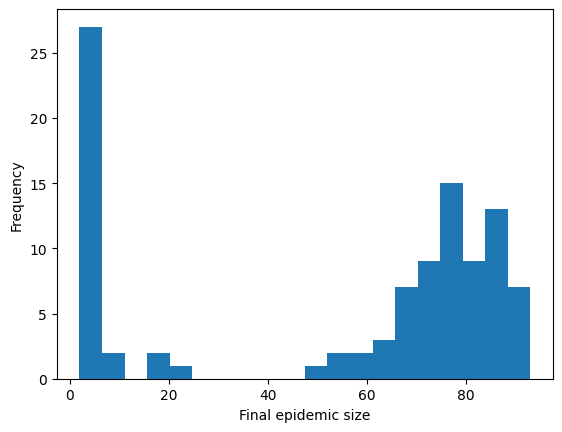

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel("Final epidemic size")
ax.set_ylabel("Frequency")

plt.hist(fes_2, bins=20)
plt.show()

In [26]:
np.mean(fes_2<20)

0.31

In [27]:
np.mean(fes_2[fes_2>20]), np.std(fes_2[fes_2>20])

(76.42028985507247, 11.597608195572612)

### 4.2 - Effect of population size

In [29]:
X0 = np.array([999,1,0])

fes_3 = sir_fes(n_sim,t_max,X0,beta,gamma)

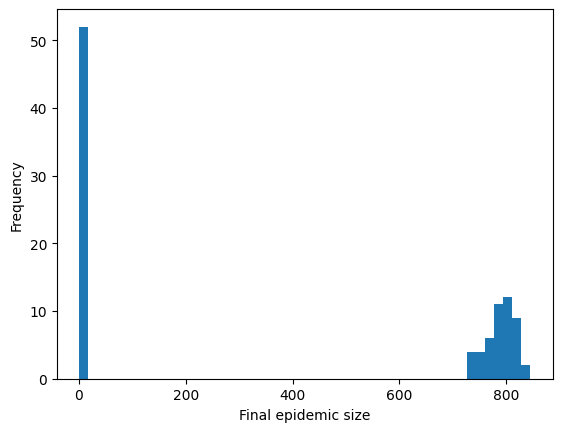

In [30]:
fig, ax = plt.subplots()
ax.set_xlabel("Final epidemic size")
ax.set_ylabel("Frequency")

plt.hist(fes_3, bins=50)
plt.show()

In [31]:
np.mean(fes_3[fes_3>100]), np.std(fes_3[fes_3>100])

(790.0, 26.8025185383762)

### 4.3 - Effect of transmission and recovery rates

In [32]:
beta = 2
gamma = 1
X0 = np.array([99,1,0])
t_max = 40
n_sim = 100

fes_4 = sir_fes(n_sim,t_max,X0,beta,gamma)

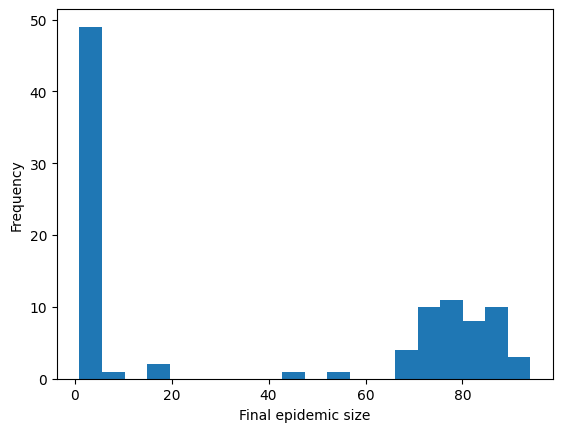

In [33]:
fig, ax = plt.subplots()
ax.set_xlabel("Final epidemic size")
ax.set_ylabel("Frequency")

plt.hist(fes_4, bins=20)
plt.show()

In [34]:
np.mean(fes_4[fes_4>20]), np.std(fes_4[fes_4>20])

(78.6875, 8.897931056337384)

# Section 5 - Vaccination

We will now consider two vaccination scenarios:
1.   Preemptive, perfect vaccination
2.   Imperfect vaccination

We will explore their impact on the probability of early extinction and the final epidemic size.

## 5.1 - Effect of preemptive vaccination

Here, we assume that a proportion $p_v$ has been immunised before the first case appears. This can be implemented without modifying the existing SIR model, instead using the initial conditions (treating vaccinated individuals as recovered).

In [35]:
beta = 1
gamma = 0.5
X0 = np.array([74,1,25])
t_max = 50
n_sim = 1000

fes_5 = sir_fes(n_sim,t_max,X0,beta,gamma)-25

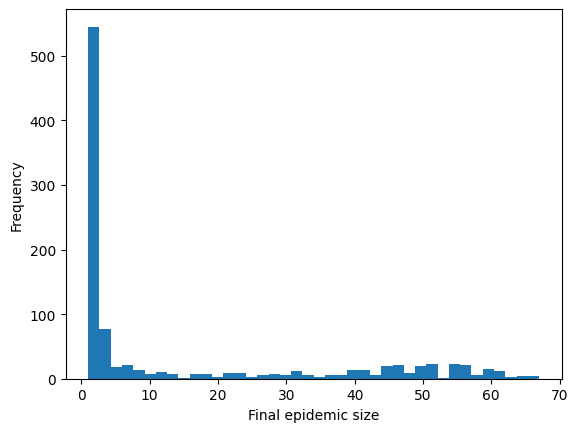

In [36]:
fig, ax = plt.subplots()
ax.set_xlabel("Final epidemic size")
ax.set_ylabel("Frequency")

plt.hist(fes_5, bins=40)
plt.show()

In [37]:
np.mean(fes_5[fes_5>20]), np.std(fes_5[fes_5>20])

(45.851063829787236, 11.547887449314052)

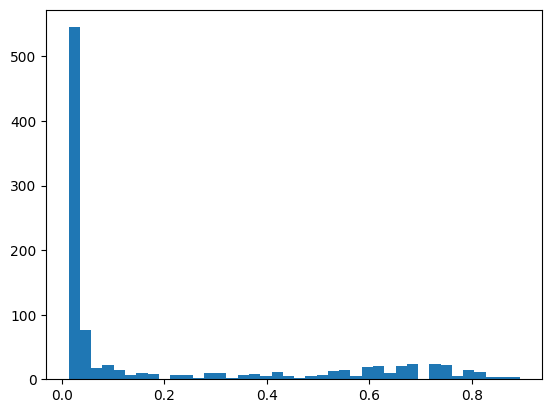

In [38]:
fig, ax = plt.subplots()
plt.hist(fes_5/75, bins=40)
plt.show()

## 5.2 - Effect of imperfect vaccine

Here, we assume that vaccinated individuals have their susceptibility reduced by a factor epsilon < 1. We will begin by assuming that the whole population has been vaccinated before the onset of the outbreak. Next, we can modify the model to allow a fraction $p_v$ of the population to be immunised before the outbreak and have their susceptibility reduced by a factor epsilon < 1.

In [39]:
beta = 0.75
gamma = 0.5
X0 = np.array([99,1,0])
t_max = 50
n_sim = 1000

fes_6 = sir_fes(n_sim,t_max,X0,beta,gamma)

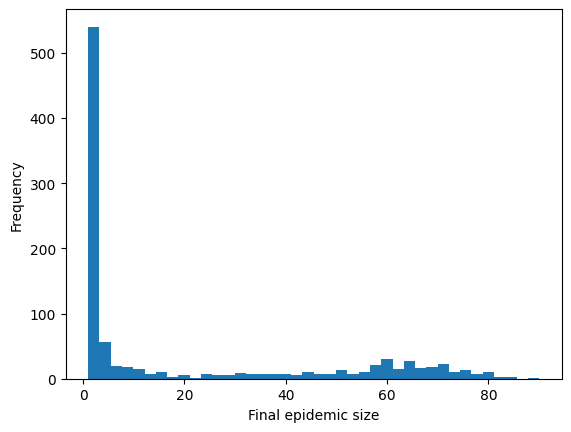

In [40]:
fig, ax = plt.subplots()
ax.set_xlabel("Final epidemic size")
ax.set_ylabel("Frequency")

plt.hist(fes_6, bins=40)
plt.show()

In [41]:
np.mean(fes_6[fes_6>20]), np.std(fes_6[fes_6>20])

(57.02127659574468, 15.669734545968671)